In [1]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
# Relies on molecular networking code from https://github.com/sdrogers/molnet

In [2]:
import sys
sys.path.append("/home/grimur/git/molnet/molnet/code")
import spec_lib

In [ ]:
# Load the GNPS spectral library for the matched MIBiG hits

In [3]:
mibig_gnps_library_file = "/home/grimur/iokr/data/mibig/matched_mibig_gnps_update_mibigid.mgf"
mibig_spectral_library = spec_lib.SpecLib(mibig_gnps_library_file)
mibig_spectral_library._load_mgf()
mibig_spectral_library.filter()

Loaded 100 spectra
Loaded 200 spectra
Loaded 300 spectra
Loaded 400 spectra
Loaded 500 spectra
Loaded 600 spectra
Loaded 700 spectra
Loaded 800 spectra
Loaded 900 spectra
Loaded 1000 spectra
Loaded 1100 spectra
Loaded 1200 spectra
Loaded 1300 spectra
Loaded 1400 spectra
Loaded 1500 spectra
Loaded 1600 spectra
Loaded 1700 spectra
Loaded 1800 spectra
Loaded 1900 spectra
Loaded 2000 spectra
Filtered 100
Filtered 200
Filtered 300
Filtered 400
Filtered 500
Filtered 600
Filtered 700
Filtered 800
Filtered 900
Filtered 1000
Filtered 1100
Filtered 1200
Filtered 1300
Filtered 1400
Filtered 1500
Filtered 1600
Filtered 1700
Filtered 1800
Filtered 1900
Filtered 2000


In [5]:
from nplinker.scoring.iokr import spectrum
import pyteomics.mgf

In [6]:
spectra_list = []
for mgf_spec in pyteomics.mgf.read('/home/grimur/iokr/data/mibig/matched_mibig_gnps_update_mibigid.mgf', use_index=False):
    spec = spectrum.MSSpectrum(mgf_dict=mgf_spec)
    spec.id = mgf_spec['params']['bgcid']
    spec.ionisation = '[M+H]+'
    if spec.smiles != 'N/A':
        spectra_list.append(spec)


In [ ]:
# Load the MIBiG structural annotations for BGC->SMILES conversion

In [7]:
import csv
bgc_structures = {}
with open('/home/grimur/iokr/data/mibig/compunds_structures_2.0.csv') as f:
    r = csv.reader(f)
    for line in r:
        bgc_id, compound_name, smiles, database_ids = line
        if not bgc_id.startswith('BGC'):
            continue
        if bgc_id in bgc_structures:
            bgc_structures[bgc_id].append(smiles)
        else:
            bgc_structures[bgc_id] = [smiles]

In [ ]:
# Init SMILES->BGC conversion

In [8]:
smiles_reverse_lookup = {}
for bgc_id, smiles_list in bgc_structures.items():
    for smiles_string in smiles_list:
        if smiles_string not in smiles_reverse_lookup:
            smiles_reverse_lookup[smiles_string] = [bgc_id]
        else:
            smiles_reverse_lookup[smiles_string].append(bgc_id)


In [9]:
smiles_list = smiles_reverse_lookup.keys()

In [ ]:
# Initilise the IOKR server and rank the spectra list against the smiles list

In [10]:
from nplinker.scoring.iokr import nplinker_iokr

['/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/cdk_pywrapper']
Server process already running: True


In [11]:
iokr_server = nplinker_iokr.get_iokr_server()
rank = iokr_server.score_smiles(spectra_list, smiles_list)

In [12]:
import numpy
smiles_list = list(smiles_list)

In [13]:
training_set_spectra_ids = set([])
iokr_spectra_data = '/home/grimur/iokr/data/spectra.txt'
with open(iokr_spectra_data, 'r') as f:
    for l in f.readlines():
        spec_id = l.split()[0]
        training_set_spectra_ids.add(spec_id)


In [14]:
# For each spectrum, loop through the SMILES matches ordered by score.
# Keep track of the corresponding BGCs. When we encounter the correct BGC, 
# we look at how many BGCs are higher ranked.


correct_ranks = []
incorrect_ranks = []

removed_smiles = set([])
for i, spectrum in enumerate(spectra_list):
    # Exclusion by spectrum ID
    spectrum_id = spectrum.id.split('.')[1]
    if spectrum_id in training_set_spectra_ids:
        continue
        
    # exclusion by INCHI key (this sucks)
    """    smiles = spectrum.smiles
    #print(smiles)
    try:
        cmp = cdk_pywrapper.cdk_pywrapper.Compound(smiles, identifier_type='smiles')
    except:
        continue
    try:
        inchi = cmp.get_inchi_key().split('-')[0]
    except:
        continue
    if inchi in training_set_inchi_keys:
        removed_smiles.add(smiles)
        continue
"""
    bgc_id = spectrum.id.split('.')[0]
    smiles_scores = rank[i, :]
    
    smiles_sorted_indices = numpy.argsort(smiles_scores)[::-1]
    
    collected_bgc_set = set([])
    for smiles_rank, smiles_index in enumerate(smiles_sorted_indices):
        #if smiles in removed_smiles:
        #    continue
        smiles = smiles_list[smiles_index]
        bgc_list = smiles_reverse_lookup[smiles]
        collected_bgc_set_add = collected_bgc_set.union(bgc_list)
        if bgc_id in collected_bgc_set_add:
            correct_ranks.append(len(collected_bgc_set))
            break
        else:
            collected_bgc_set = collected_bgc_set_add

    # Create null distribution by shuffling the rank of the IOKR scores
    numpy.random.shuffle(smiles_sorted_indices)
    
    collected_bgc_set = set([])
    for smiles_rank, smiles_index in enumerate(smiles_sorted_indices):
        #if smiles in removed_smiles:
        #    continue
        smiles = smiles_list[smiles_index]
        bgc_list = smiles_reverse_lookup[smiles]
        collected_bgc_set_add = collected_bgc_set.union(bgc_list)
        if bgc_id in collected_bgc_set_add:
            incorrect_ranks.append(len(collected_bgc_set))
            break
        else:
            collected_bgc_set = collected_bgc_set_add


In [ ]:
# Plot

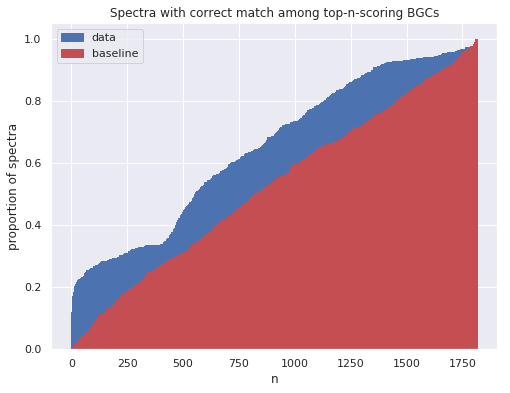

In [40]:
plt.figure(figsize=(8, 6))

#bins = bgc_count
bins = len(bgc_structures.keys())
plt.hist(correct_ranks, cumulative=True, range=[0, bins], bins=bins, edgecolor='b', density=True, label='data')
plt.hist(incorrect_ranks, cumulative=True, range=[0, bins], bins=bins, edgecolor='r', density=True, color='r', label='baseline')

plt.title('Spectra with correct match among top-n-scoring BGCs')

plt.xlabel('n')
plt.ylabel('proportion of spectra')
plt.legend()

# plt.savefig('graph_iokr_mibig_gnps_vs_baseline.pdf')

In [16]:
bgc_count = len(bgc_structures.keys())

for cutoff in (0, 5, 10, 20, 200):
    res = []
    for test_type in (correct_ranks, incorrect_ranks):
        res.append(len([x for x in test_type if x <= cutoff]) / len(test_type))
    print('top-{} -- {}, {}'.format(cutoff, res[0], res[1]))

res = []
for test_type in (correct_ranks, incorrect_ranks):
    auc = 0
    for i in range(bgc_count):
        proportion = len([x for x in test_type if x<= i]) / len(test_type)
        auc += proportion
    res.append((auc / bgc_count))
    
print('auc -- {}, {}'.format(*res))

top-0 -- 0.12076583210603829, 0.0014727540500736377
top-5 -- 0.17083946980854198, 0.008836524300441826
top-10 -- 0.187039764359352, 0.014727540500736377
top-20 -- 0.21207658321060383, 0.020618556701030927
top-200 -- 0.29455081001472755, 0.15758468335787923
auc -- 0.6533610583067847, 0.5254512336748118


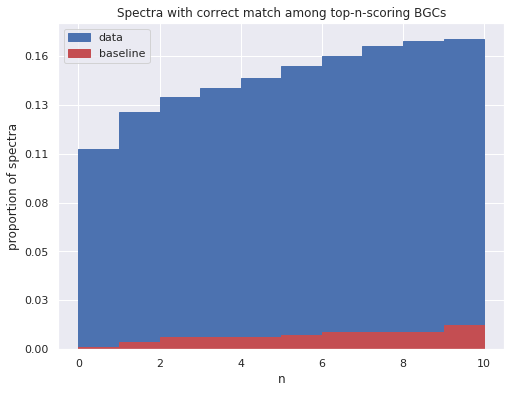

In [18]:
p, ax1 = plt.subplots(figsize=(8, 6))

# plt.figure(figsize=(8, 6))

bins = bgc_count
ax1.hist(correct_ranks, cumulative=True, range=[0, 10], bins=10, edgecolor='b', density=False, label='data')
ax1.hist(incorrect_ranks, cumulative=True, range=[0, 10], bins=10, edgecolor='r', density=False, color='r', label='baseline')

ax1.set_title('Spectra with correct match among top-n-scoring BGCs')

ax1.set_xlabel('n')
ax1.set_ylabel('proportion of spectra')

y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:.2f}'.format(round(x / len(spectra_list), 2)) for x in y_vals])

ax1.legend()

# plt.savefig('graph_iokr_mibig_gnps_vs_baseline_zoom.pdf')

In [ ]:
import csv
with open('data_iokr_mibig_gnps_vs_baseline.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(zip(correct_ranks, incorrect_ranks))

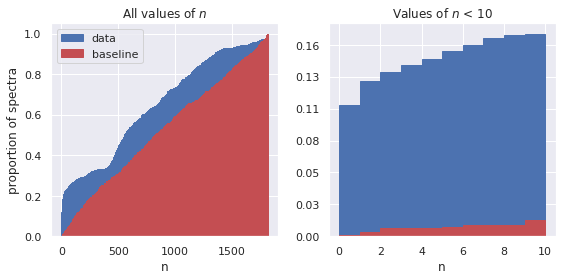

In [23]:
p, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

#bins = bgc_count
bins = len(bgc_structures.keys())
ax1.hist(correct_ranks, cumulative=True, range=[0, bins], bins=bins, edgecolor='b', density=True, label='data')
ax1.hist(incorrect_ranks, cumulative=True, range=[0, bins], bins=bins, edgecolor='r', density=True, color='r', label='baseline')


ax1.set_xlabel('n')
ax1.set_ylabel('proportion of spectra')

ax1.set_title("All values of $n$")
# plt.legend()

bins = bgc_count
ax2.hist(correct_ranks, cumulative=True, range=[0, 10], bins=10, edgecolor='b', density=False, label='data')
ax2.hist(incorrect_ranks, cumulative=True, range=[0, 10], bins=10, edgecolor='r', density=False, color='r', label='baseline')

ax2.set_title('Values of $n$ < 10')

ax2.set_xlabel('n')
#ax2.set_ylabel('proportion of spectra')

y_vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.2f}'.format(round(x / len(spectra_list), 2)) for x in y_vals])

plt.tight_layout()

# Need the extra bits for the title to come out right
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#p.suptitle('Spectra with correct match among top-n-scoring BGCs')

ax1.legend()

plt.savefig('20200514_graph_iokr_mibig_gnps_vs_baseline_2panel.pdf')

In [ ]:
# For SI

In [31]:
with open('gnps_mibig_smiles.csv', 'w') as f:
    w = csv.writer(f, delimiter=',', quotechar='"')
    for i, spectrum in enumerate(spectra_list):
        # Exclusion by spectrum ID
        spectrum_id = spectrum.id.split('.')[1]
        if spectrum_id in training_set_spectra_ids:
            continue

        bgc_id = spectrum.id.split('.')[0]
        smiles_list = bgc_structures[bgc_id]
        for smiles in smiles_list:
            w.writerow([spectrum_id, bgc_id, smiles])